In [2]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown

#modeling
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import precision_score, accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB

#text processing
import re as rgx
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize 
from nltk.corpus import wordnet

seed = 1234

[nltk_data] Downloading package stopwords to /Users/lou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/lou/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#  Automatic sentiment prediction on reviews

PROJECT GOAL

Train a classification model that predicts positive sentiment on reviews that are then automatically uploaded to the clients website

# Classification metrics 

Accuracy: Accuracy measures the overall correctness of the model's predictions by calculating the ratio of correctly classified instances to the total number of instances. It provides a general measure of the model's performance but may not be suitable for imbalanced datasets.

Precision: Precision calculates the proportion of true positive predictions (correctly predicted positive instances) out of all positive predictions (true positives + false positives). It focuses on the accuracy of positive predictions and is useful when the cost of false positives is high. Precision = TruePositives / (TruePositives + FalsePositives)

Precision — Out of all the examples that predicted as positive, how many are really positive? A higher precision value means fewer false positives.

In [3]:
#importing raw data
raw_data = pd.read_csv('/Users/lou/Desktop/projects/DATA/yelp.csv', low_memory=False)
#importing data to manipulate
df = pd.read_csv('/Users/lou/Desktop/projects/DATA/yelp.csv', low_memory=False)


In [4]:
# function to map stars to class
def map_stars_to_class(star):
    if star in [1, 2, 3]:
        return 0
    elif star in [4, 5]:
        return 1
    
df['class'] = df['stars'].apply(map_stars_to_class)

# Multinomial Naive Bayes

In [7]:
## Split the data

X = df['text'] # feature
y = df['class'] # target

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,stratify=y,random_state=seed)

# Initial tuned Model

Cross-Validation Accuracy: [0.839375 0.8425   0.848125 0.84625  0.8425   0.82875  0.846875 0.8425
 0.83375  0.85     0.836875 0.851875 0.840625 0.853125 0.85125 ]
Accuracy: 83.80%
Precision: 87.28%


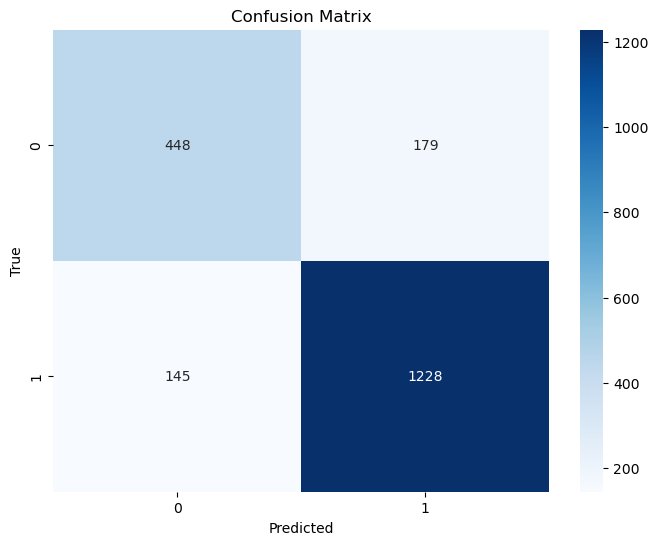

In [33]:
# CountVectorizer with the best parameters
vectorizer = CountVectorizer(binary=True, min_df=0.001, ngram_range=(1, 2))

X_train_vectorized = vectorizer.fit_transform(X_train)

# MultinomialNB
clf = MultinomialNB(alpha=1)

cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=seed)  
cv_scores = cross_val_score(clf, X_train_vectorized, y_train, cv=cv)

clf.fit(X_train_vectorized, y_train)

X_test_vectorized = vectorizer.transform(X_test)

y_pred = clf.predict(X_test_vectorized)

accuracy = clf.score(X_test_vectorized, y_test)
precision = precision_score(y_test, y_pred)

print("Cross-Validation Accuracy: {}".format(cv_scores))
print("Accuracy: {:.2%}".format(accuracy))
print("Precision: {:.2%}".format(precision))

predicted = clf.predict(X_test_vectorized)

cm = confusion_matrix(y_test, predicted)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")


plt.show()

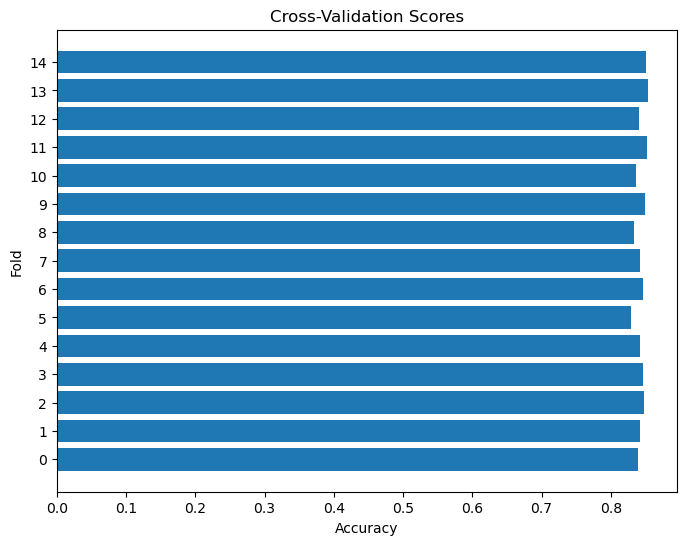

In [34]:
plt.figure(figsize=(8, 6))
plt.barh(range(len(cv_scores)), cv_scores)
plt.ylabel("Fold")
plt.xlabel("Accuracy")
plt.title("Cross-Validation Scores")
plt.yticks(np.arange(len(cv_scores)))
plt.show()

# Increasing Precision

# Undersampling the majority class

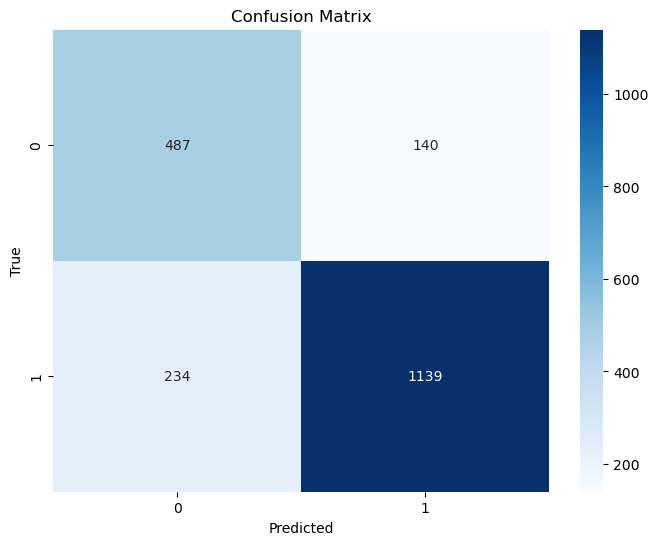

Cross-Validation Scores: [0.81673307 0.81673307 0.82171315 0.84063745 0.812749   0.83167331
 0.81673307 0.82171315 0.8187251  0.82768924 0.82071713 0.83167331
 0.82071713 0.81075697 0.8376494 ]
Mean Cross-Validation Accuracy: 82.31%
Accuracy: 81.30%
Precision: 89.05%


In [37]:
vectorizer = CountVectorizer(binary=True, min_df=0.001, ngram_range=(1, 2))

X_train_vectorized = vectorizer.fit_transform(X_train)

undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_vectorized, y_train)

clf = MultinomialNB(alpha=1)

cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=seed)  
cv_scores = cross_val_score(clf, X_train_resampled, y_train_resampled, cv=cv)

clf.fit(X_train_resampled, y_train_resampled)

X_test_vectorized = vectorizer.transform(X_test)

predicted = clf.predict(X_test_vectorized)

accuracy = accuracy_score(y_test, predicted)
precision = precision_score(y_test, predicted)

cm = confusion_matrix(y_test, predicted)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("Cross-Validation Scores: {}".format(cv_scores))
print("Mean Cross-Validation Accuracy: {:.2%}".format(cv_scores.mean()))
print("Accuracy: {:.2%}".format(accuracy))
print("Precision: {:.2%}".format(precision))

# Exploring false positives

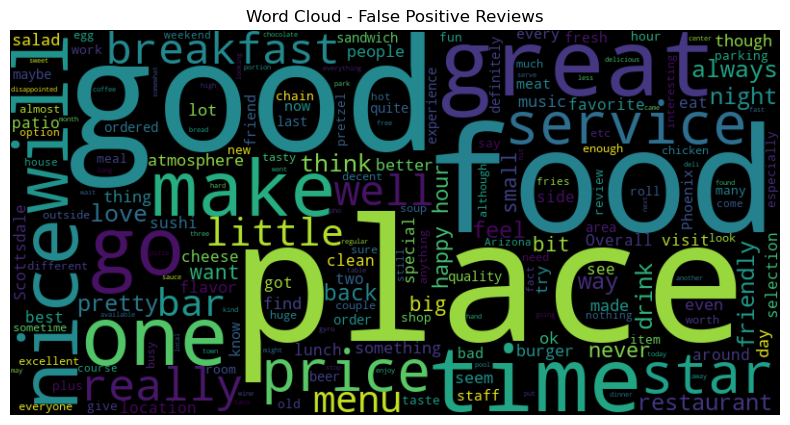

In [38]:
from wordcloud import WordCloud


false_positive_rows = X_test[(y_test == 0) & (predicted == 1)]
true_positive_rows = X_test[(y_test == 1) & (predicted == 1)]


# Combine false positive reviews into a single string
false_positive_text = ' '.join(false_positive_rows)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400).generate(false_positive_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - False Positive Reviews')
plt.show()

# Adding stopwords

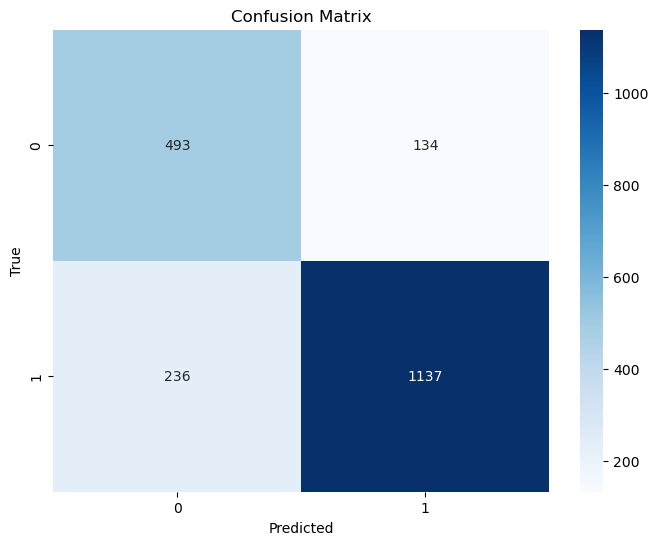

Cross-Validation Scores: [0.81374502 0.79681275 0.81772908 0.78585657 0.82868526 0.80478088
 0.80278884 0.82270916 0.81673307 0.79482072 0.81075697 0.79282869
 0.79681275 0.80478088 0.84760956]
Mean Cross-Validation Accuracy: 80.92%
Accuracy: 81.50%
Precision: 89.46%


In [42]:
def remove_stop_words(data, stop_words=[], binary=True, min_df=0.001, ngram_range=(1, 2)):
    vectorizer = CountVectorizer(stop_words=stop_words, binary=binary, min_df=min_df, ngram_range=ngram_range)
    X = vectorizer.fit_transform(data)
    return X, vectorizer

stop_words = ['go','new','dinner','taco','fresh','phoenix','that', 'with', 'are', 'they', 'on', 
              'place', 'have', 'not', 'had', 'there', 'good', 'great', 'my', 'like', 'so', 'we', 'as', 
              'food','nice','great', 'restaurant', 'service', 'time', 'food', 'friendly', 'pretty']

X, y = df['text'], df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=seed)

X_train_vectorized, vectorizer = remove_stop_words(X_train, stop_words)
X_test_vectorized = vectorizer.transform(X_test)

undersampler = RandomUnderSampler(random_state=seed)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_vectorized, y_train)

clf = MultinomialNB(alpha=2)

cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=seed)
cv_scores = cross_val_score(clf, X_train_resampled, y_train_resampled, cv=cv)

clf.fit(X_train_resampled, y_train_resampled)

predicted = clf.predict(X_test_vectorized)

accuracy = accuracy_score(y_test, predicted)
precision = precision_score(y_test, predicted)

cm = confusion_matrix(y_test, predicted)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("Cross-Validation Scores: {}".format(cv_scores))
print("Mean Cross-Validation Accuracy: {:.2%}".format(cv_scores.mean()))
print("Accuracy: {:.2%}".format(accuracy))
print("Precision: {:.2%}".format(precision))

# Confidence of true positives
predicted probability values represent the estimated likelihood of each class label for a given input 

The Naive Bayes classifier uses the Bayes' theorem to calculate these probabilities. It assumes that the features are conditionally independent.

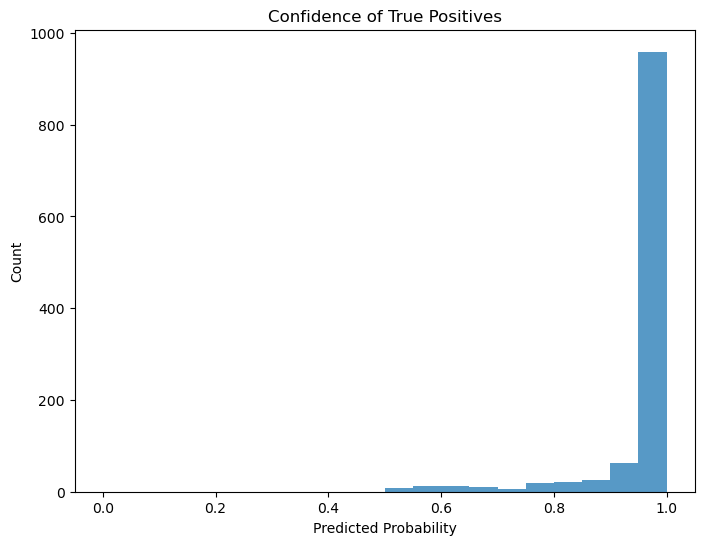

In [43]:
predicted = clf.predict(X_test_vectorized)
predicted_proba = clf.predict_proba(X_test_vectorized)[:, 1]

true_positive_mask = np.logical_and(predicted == 1, y_test == 1)
true_positive_probs = predicted_proba[true_positive_mask]
confidence_scores = predicted_proba

plt.figure(figsize=(8, 6))
plt.hist(true_positive_probs, bins=20, range=(0, 1), alpha=0.75)
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.title("Confidence of True Positives")
plt.show()

# Defining a new predicted probabilties threshold

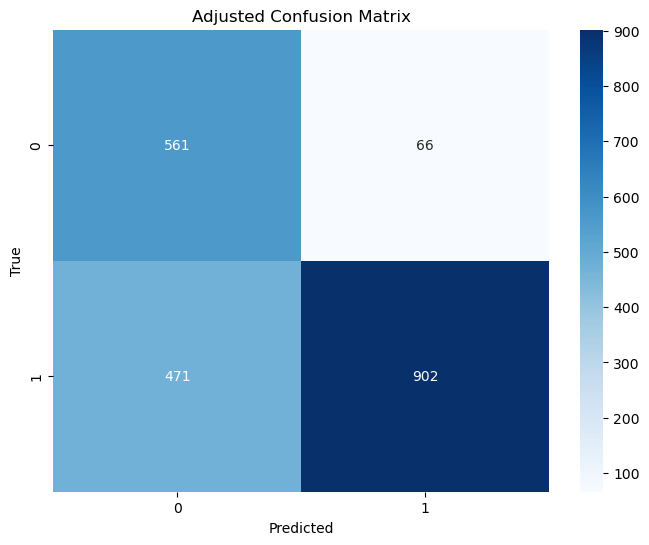

Adjusted Accuracy: 73.15%
Adjusted Precision: 93.18%


In [55]:
vectorizer = CountVectorizer(binary=True, min_df=0.001, ngram_range=(1, 2))
X_train_vectorized = vectorizer.fit_transform(X_train)

undersampler = RandomUnderSampler(random_state=seed)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_vectorized, y_train)

clf = MultinomialNB(alpha=2)
clf.fit(X_train_resampled, y_train_resampled)

X_test_vectorized = vectorizer.transform(X_test)

predicted_probabilities = clf.predict_proba(X_test_vectorized)[:, 1]

# Define the new threshold
new_threshold = 0.99

adjusted_predicted = (predicted_probabilities >= new_threshold).astype(int)

adjusted_cm = confusion_matrix(y_test, adjusted_predicted)
adjusted_accuracy = accuracy_score(y_test, adjusted_predicted)
adjusted_precision = precision_score(y_test, adjusted_predicted)

plt.figure(figsize=(8, 6))
sns.heatmap(adjusted_cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Adjusted Confusion Matrix")
plt.show()

print("Adjusted Accuracy: {:.2%}".format(adjusted_accuracy))
print("Adjusted Precision: {:.2%}".format(adjusted_precision))


# Final Model

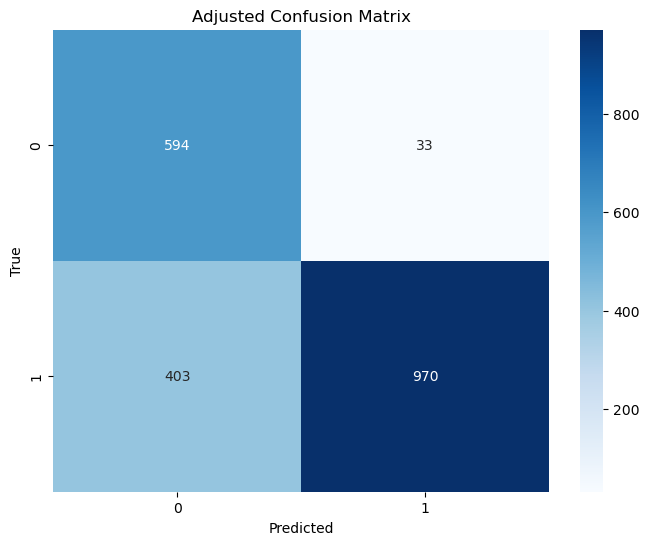

Adjusted Accuracy: 78.20%
Adjusted Precision: 96.71%


In [59]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

vectorizer = CountVectorizer(binary=True, min_df=0.001, ngram_range=(1, 2))
X_vectorized = vectorizer.fit_transform(X)

undersampler = RandomUnderSampler(random_state=seed)
X_resampled, y_resampled = undersampler.fit_resample(X_vectorized, y)

clf = MultinomialNB(alpha=2)
clf.fit(X_resampled, y_resampled)

X_test_vectorized = vectorizer.transform(X_test)

predicted_probabilities = clf.predict_proba(X_test_vectorized)[:, 1]

new_threshold = 0.99

adjusted_predicted = (predicted_probabilities >= new_threshold).astype(int)

adjusted_cm = confusion_matrix(y_test, adjusted_predicted)
adjusted_accuracy = accuracy_score(y_test, adjusted_predicted)
adjusted_precision = precision_score(y_test, adjusted_predicted)

plt.figure(figsize=(8, 6))
sns.heatmap(adjusted_cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Adjusted Confusion Matrix")
plt.show()

print("Adjusted Accuracy: {:.2%}".format(adjusted_accuracy))
print("Adjusted Precision: {:.2%}".format(adjusted_precision))


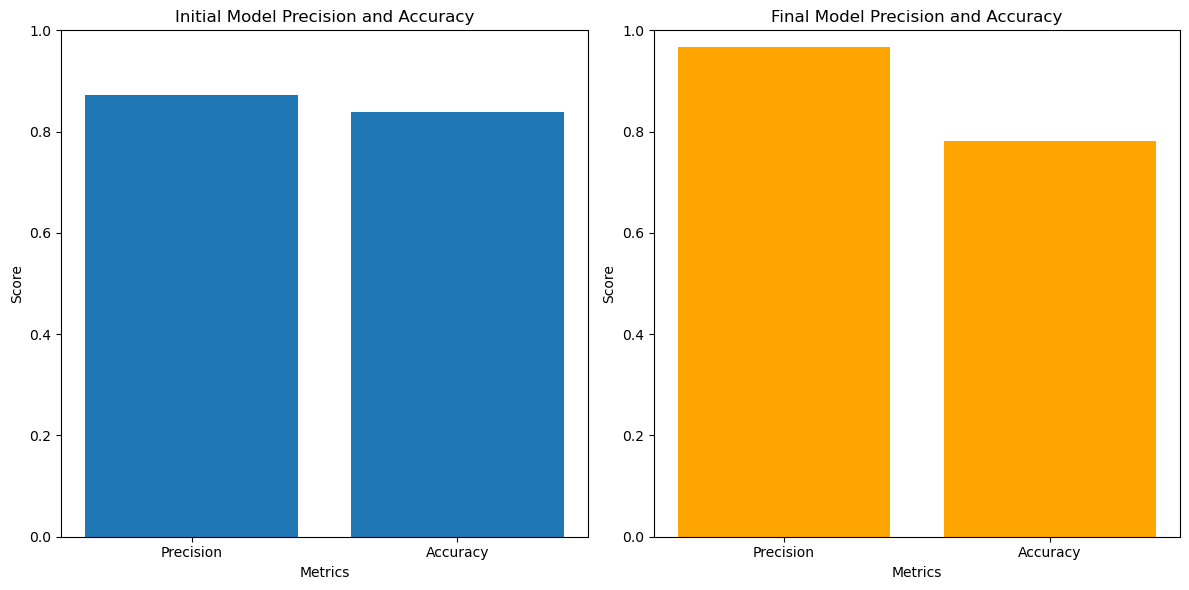

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Initial model
initial_precision = 0.8728
initial_accuracy = 0.8380

# Final model
final_precision = 0.9671
final_accuracy = 0.7820

# Set the figure size and create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the initial model results
axs[0].bar(['Precision', 'Accuracy'], [initial_precision, initial_accuracy])
axs[0].set_ylim([0, 1])
axs[0].set_xlabel('Metrics')
axs[0].set_ylabel('Score')
axs[0].set_title('Initial Model Precision and Accuracy')

# Plot the final model results
axs[1].bar(['Precision', 'Accuracy'], [final_precision, final_accuracy],color='orange')
axs[1].set_ylim([0, 1])
axs[1].set_xlabel('Metrics')
axs[1].set_ylabel('Score')
axs[1].set_title('Final Model Precision and Accuracy')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


# Extracted false positives

# "The atmosphere was relaxing and casual, and the bathrooms were fabulous!! Well lit, great aroma, and my choice between cloth hand towels or paper. The bathroom had well placed mirrors which made the space feel big and clean."


# "The happy hour is a great benefit if you can get away from work before it ends."

# "The malt was nice and malty which I really appreciated and was rather thick even after melting slightly."

# Model Parameters

Vectorizer - performs a process called tokenization and creates a numerical representation of the text data. It converts each review into a feature vector representation

Vectorizer parameters

Binary = True

When Binary is set to True, CountVectorizer converts the word occurrences to either 0 or 1. It indicates the presence or absence of a word in a document but disregards the frequency of occurrences.
Setting Binary to True can be useful when you're interested in the presence or absence of words rather than their frequency.

min_df = 0.001

min_df stands for minimum document frequency.
It is a value that represents the minimum number of documents in which a word must appear to be considered as a feature.
By default, min_df is set to 1, which means a word must appear in at least one document to be included as a feature.
Setting min_df to 0.001 means that a word must appear in at least 0.1% of the documents to be considered a feature. It helps filter out rare words that may not contribute much to the overall understanding or analysis

ngram_range = (1,2)

An n-gram is a sequence of n words. For example, a unigram (n=1) represents a single word, while a bigram (n=2) represents a sequence of two consecutive words.
The ngram_range parameter takes a tuple specifying the minimum and maximum values for n.
In the given example, ngram_range = (1, 2) means that both unigrams and bigrams will be considered as features.


Multinomial NB - In this case the Multinomial Naive Bayes model learns from labeled text data, builds a vocabulary, and calculates probabilities based on the occurrences of words in each class. During prediction, it uses these probabilities to classify new documents into the most likely class.


Multinomial NB parameters

alpha = 0.1

The alpha parameter in Multinomial Naive Bayes represents the additive smoothing parameter. It is used to handle the issue of zero probabilities when calculating the likelihood of a feature occurring in a class, especially when there are no occurrences of that feature in the training data.

In scikit-learn's MultinomialNB class, the default value for alpha is 1. By setting alpha to a smaller value, such as 0.1, we are applying a lighter smoothing effect. 

With alpha set to 0.1, the model is more confident in the observed frequencies and relies less on the smoothing effect. Most of the rare words are dealt to with the min_df param in vectorizer.